# Download and Composite DEM terrain from TNRIS v1.3


***
 - Portions created by:   __Alec Carruthers__
 >_University of Texas<br>
   Center for Water and the Environment<br>
  aleccarruthers@utexas.edu_

 - Portions created by:   __Andy Carter, PE__
 >_LandDev Consulting, LLC<br>
  4201 W. Parmer Ln, Suite C-100 <br>
  Austin, Texas 78727 <br>
  (o) 512.872.6696 x634 <br>
  andy.carter@landdevconsulting.com_

 - Created On:   __31 January 2020__<br><br>
 - Last revised:  __Verison 1.3  // 10 Feb 2020__<br><br>
 
 - Purpose:
 >This routine utilizes an input polygon shape of a requested area and intersects it with the TNRIS LiDAR index https://s3.amazonaws.com/data.tnris.org/0549d3ba-3f72-4710-b26c-28c65df9c70d/assets/central-texas-lidar-tile-index.zip. From this intersection the routine makes requests to TNRIS to download, unzip and store the necessary tiles.  Once stored, these files are merged into a single DEM and written with the appropriate metadata.
 
 - Inputs required:
  > 1) ESRI Shapefile of the TNRIS LiDAR Tile index in Web Mercator projection (EPSG: 3857)<br>
    2) ESRI Shapefile of the area to be sampled in Web Mercator projection (EPSG: 3857)<br>
    
 - Output generated:
  > Single GeoTIFF DEM

***
### 1.0 References

Geopandas is used to perform the geoprocessing of the shapefiles.  This uses GDAL and Fiona.  Decartes is needed for plotting<br>
Rasterio is used for reading, plotting and merging the raster images<br>

In [1]:
import numpy as np
import pandas as pd

import geopandas as gpd
import rasterio

import requests, zipfile, io

import os
import glob
import matplotlib.pyplot as plt
import re

from rasterio.merge import merge
from rasterio.plot import show
from rasterio import features

from multiprocessing.pool import ThreadPool

***
### 2.0 Input Data

The Lidar_availablilty_04302018.shp is in Web Mercator (EPSG: 3857) and was downloaded from TNRIS<br>
The sampled area is a polygon that is created by the user and set to the Web Mercator CRS (EPSG: 3857)<br>


In [2]:
# Path to folder holding Tile Index Shapefile
strIndexPath = r"C:\LandDev\204301.018_HeroWay\JuPYter_TileIndex\lidar_availablilty_04302018.shp"

# Path to folder holding Watershed Shapefile
strWatershedPath = r"C:\LandDev\Research_Park\SHP\AOI_3857_AR.shp"

# Path to store the intersection shapefile
strIntersectionPath = r"C:\LandDev\Research_Park\TerrainHarvest\Merge_AR.shp"

# Path to store the downloaded DEM zip file - Path to folder holding DEMs to merge
strDEMDownloadPath = r"C:\LandDev\Research_Park\TerrainHarvest"

# Output path where the merged GeoTIFF will be placed
strOutTiffPath = r"C:\LandDev\Research_Park\TerrainHarvest\dem_merge.tif"

***
### 3.0 Read in Shapefiles

Using geopandas, read in the shapefile and plot check data

In [3]:
# Read the two shapefiles using geopandas
df1 = gpd.read_file(strIndexPath)
df2 = gpd.read_file(strWatershedPath)

In [4]:
print(df1.crs)
print(df2.crs)

{'init': 'epsg:3857'}
{'init': 'epsg:3857'}


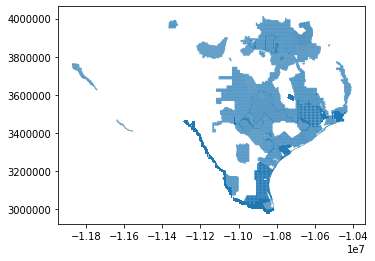

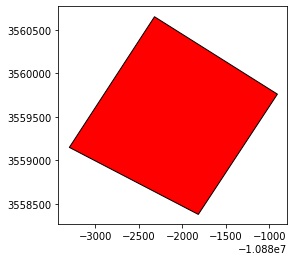

In [5]:
#Plot the TNRIS liDAR index ESRI shapefile
df1.plot();
#Plot the overlay polygon for the area to be querried
df2.plot(color='red', edgecolor='black');

In [6]:
# To intersect, both shapefiles need to be on the same CRS
# TODO - Check and if necessary convert each of the shapefiles to the correct CRS - Web Mercator EPSG 3857
df3 = gpd.overlay(df1, df2, how='intersection')

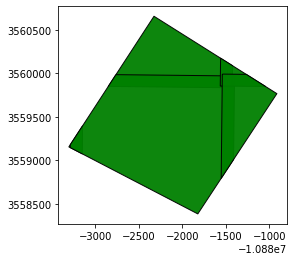

In [7]:
# Plot the intersected shapefile
df3.plot(color='green', edgecolor='black', alpha=0.95)

In [8]:
#Save a copy of the intersection shapefile
df3.to_file(strIntersectionPath)

In [9]:
#Show the attribute table for the merged shapefile for the first three records
df3.head(3)

,tilename,demname,dirname,las_size_m,dem_size_m,Shape_Leng,Shape_Area,Name,descriptio,timestamp,begin,end,altitudeMo,tessellate,extrude,visibility,drawOrder,icon,geometry
0,stratmap17-50cm_3097342d4,stratmap17-1m_3097342d4,stratmap-2017-50cm-central-texas,732.834936,13.0,8064.025621,4.045211e+06,AOI_1,None,None,None,None,None,1,0,-1,None,None,"POLYGON Z ((-10881420.282 3560086.085 0.000, -..."
1,stratmap17-50cm_3097344b1,stratmap17-1m_3097344b1,stratmap-2017-50cm-central-texas,715.261646,13.0,8065.099884,4.046459e+06,AOI_1,None,None,None,None,None,1,0,-1,None,None,"POLYGON Z ((-10883144.556 3559395.463 0.000, -..."
2,stratmap17-50cm_3097344b2,stratmap17-1m_3097344b2,stratmap-2017-50cm-central-texas,614.852404,13.0,8065.064035,4.046423e+06,AOI_1,None,None,None,None,None,1,0,-1,None,None,"POLYGON Z ((-10882761.119 3559983.777 0.000, -..."


***
### 4.0 Create List of Tiles needed and Tiles to download

Using geopandas, read in the shapefile and plot check data

In [10]:
#Use the demname to look-up the dirname which is the header value
listDIRName = df3['dirname']
listDEMname = df3['demname']

z = [] #A temporary list
for i in listDEMname:
    #For each demname, get the 7 digit tile name
    #This routine looks for 7 numbers in a row - pattern matching with regular expression
    strTileRegex = re.compile(r'\d{7}') #Looks for a match to seven numbers in a row
    strTileNum = strTileRegex.search(i)
    i = strTileNum.group()
    z.append(i)

listDEMname = z

# using dictionary comprehension 
# to convert lists to dictionary 
# This will return a unique a unique dictionary of the tiles needed
dictResults = {listDEMname[i]: listDIRName[i] for i in range(len(listDEMname))} 
print(str(dictResults))

#These are the TNRIS tile ID's that need to be downloaded.

{'3097342': 'stratmap-2017-50cm-central-texas', '3097344': 'stratmap-2017-50cm-central-texas', '3097351': 'stratmap-2017-50cm-central-texas', '3097353': 'stratmap-2017-50cm-central-texas'}


***
### 5.0 Clear and Delete any existing DEMs downloaded

In [11]:
#Clear and delete the old strDEMDownloadPath Directory

for filename in os.listdir(strDEMDownloadPath):
    file_path = os.path.join(strDEMDownloadPath,filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

***
### 6.0 Download the requested tiles 


In [12]:
for i in dictResults:
        print(str(dictResults.get(i,0)))

stratmap-2017-50cm-central-texas
stratmap-2017-50cm-central-texas
stratmap-2017-50cm-central-texas
stratmap-2017-50cm-central-texas


In [13]:
#Function - Get the TNRIS GUID for each dataset
#TODO - expand to all the TNRIS available datasets

def getTNRIS_GUID(argument):
        switcher = {
            "stratmap-2017-50cm-central-texas": "0549d3ba-3f72-4710-b26c-28c65df9c70d",
            "stratmap-2009-50cm-tarrant": "7bc5f57d-f679-454f-8fd3-bdffc8d54272",
            "stratmap09-1m-dallas": "9aba8b42-4a55-4687-95aa-5a7cf75c970a",
            "lcra-2007-140cm": "ab743202-206c-4c37-99b1-9a46db93bd4c",
            "stratmap-2017-50cm-jefferson": "12342f12-2d74-44c4-9f00-a5c12ac2659c",
            "fema-2016-70cm-dewitt": "4bd279fc-e358-4cdb-abc0-4e34516b21d3",
            "stratmap-2011-50cm-blanco-kendall-kerr": "760f9068-426e-4c30-9829-177259d1da0f",
        }
        return switcher.get(argument, "Nothing_Found")
    
#Function - Get the Tile Header for each dataset
# Note that the Tile header is not always equal to the dirname - UGH!

def getTNRIS_TileHeader(argument):
        switcher = {
            "stratmap-2017-50cm-central-texas": "stratmap17-50cm-central-texas",
            "stratmap09-50cm-tarrant": "stratmap09-50cm-tarrant",
            "stratmap09-1m-dallas": "stratmap09-1m-dallas",
            "lcra07-140cm": "lcra07-140cm",
            "stratmap-2017-50cm-jefferson": "stratmap17-50cm-jefferson",
            "fema-2016-70cm-dewitt": "fema16-70cm-dewitt",
            "stratmap-2011-50cm-blanco-kendall-kerr": "stratmap11-50cm-blanco-kendall-kerr",
        }
        return switcher.get(argument, "Nothing_Found")


In [14]:
def funcDownloadTiles(tileURL):
    #Download each zip file and extract to the strDEMDownloadPath
    r = requests.get(tileURL)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(strDEMDownloadPath)
    
    #return strRequestedTile

In [15]:
#Download the tiles that are contained the in the "dictResults" list from above

urls = []

for i in dictResults:
    # Does each source have a different GUID on the AWS? - 2020.02.04
    strURLpath = (r"https://s3.amazonaws.com/data.tnris.org/")
    strURLpath += getTNRIS_GUID(str(dictResults.get(i,0)))
    strURLpath += (r"/resources/")
    strURLpath += getTNRIS_TileHeader(str(dictResults.get(i,0)))
    strURLpath += (r"_") + i + "_dem.zip"
    print(strURLpath)
    urls.append(strURLpath)

    #Download each zip file and extract to the strDEMDownloadPath
    #r = requests.get(strURLpath)
    #z = zipfile.ZipFile(io.BytesIO(r.content))
    #z.extractall(strDEMDownloadPath)

#print(urls)

https://s3.amazonaws.com/data.tnris.org/0549d3ba-3f72-4710-b26c-28c65df9c70d/resources/stratmap17-50cm-central-texas_3097342_dem.zip
https://s3.amazonaws.com/data.tnris.org/0549d3ba-3f72-4710-b26c-28c65df9c70d/resources/stratmap17-50cm-central-texas_3097344_dem.zip
https://s3.amazonaws.com/data.tnris.org/0549d3ba-3f72-4710-b26c-28c65df9c70d/resources/stratmap17-50cm-central-texas_3097351_dem.zip
https://s3.amazonaws.com/data.tnris.org/0549d3ba-3f72-4710-b26c-28c65df9c70d/resources/stratmap17-50cm-central-texas_3097353_dem.zip


In [16]:
i=0
results = ThreadPool(10).imap_unordered(funcDownloadTiles, urls)
for strRequestedTile in results:
    i += 1
    print(i)

print("Complete")

1
2
3
4
Complete


***
### 7.0  Delete all the tiles that are not wihtin the requested area

In [17]:
a = df3['demname']
#Create a list of tiles with full name so the strDEMDownloadPath can be cleaned up.
c = []
for i in a:
    c.append(i)

#Using list comprehension to add '.img' to each item in the list
c = [i + '.img' for i in c]
print(c)

['stratmap17-1m_3097342d4.img', 'stratmap17-1m_3097344b1.img', 'stratmap17-1m_3097344b2.img', 'stratmap17-1m_3097351c3.img', 'stratmap17-1m_3097353a1.img']


In [18]:
#Go through the strDEMDownloadPath and remove all files that do not match an item in the c[] list above.
for filename in os.listdir(strDEMDownloadPath):
    if filename not in c:
        file_path = os.path.join(strDEMDownloadPath,filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

***
### 8.0  Merge the downloaded DEMs to a Single GeoTiff

>Code below is modified from original code from Alec Carruthers

In [19]:
# Create a list of all the files to merge 
# https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-mosaic.html

search_criteria = "*"
q = os.path.join(strDEMDownloadPath, search_criteria)
dem_files = glob.glob(q)
dem_files[:6]

['C:\\LandDev\\Research_Park\\TerrainHarvest\\stratmap17-1m_3097342d4.img',
 'C:\\LandDev\\Research_Park\\TerrainHarvest\\stratmap17-1m_3097344b1.img',
 'C:\\LandDev\\Research_Park\\TerrainHarvest\\stratmap17-1m_3097344b2.img',
 'C:\\LandDev\\Research_Park\\TerrainHarvest\\stratmap17-1m_3097351c3.img',
 'C:\\LandDev\\Research_Park\\TerrainHarvest\\stratmap17-1m_3097353a1.img']

In [20]:
# Empty list to store opened DEM files
d = []
for file in dem_files:
    src = rasterio.open(file)
    d.append(src)

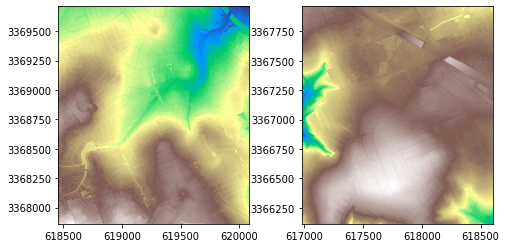

In [21]:
# Sample plots of the first two rasters
fig, (ax1,ax2) = plt.subplots(ncols=2,nrows=1,figsize=(8,4))
show(d[0],ax=ax1, cmap='terrain')
show(d[1],ax=ax2, cmap='terrain')

In [22]:
# Coordinate Reference System
d[0].meta

{'driver': 'HFA',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 1620,
 'height': 1849,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:26914'),
 'transform': Affine(1.0, 0.0, 618462.0,
        0.0, -1.0, 3369711.0)}

In [23]:
# Check Meta Data of original Files
out_meta = src.meta.copy()
out_meta

{'driver': 'HFA',
 'dtype': 'float32',
 'nodata': -9999.0,
 'width': 1621,
 'height': 1849,
 'count': 1,
 'crs': CRS.from_dict(init='epsg:26914'),
 'transform': Affine(1.0, 0.0, 619981.0,
        0.0, -1.0, 3367996.0)}

In [24]:
mosaic, out_trans = merge(d)

In [25]:
# Create Metadata of the for the mosaic TIFF
out_meta.update({"driver": "HFA","height":mosaic.shape[1],"width":mosaic.shape[2],"transform": out_trans,})

In [26]:
# Write the updated DEM to the specified file path
with rasterio.open(strOutTiffPath, "w", **out_meta) as dest:
    dest.write(mosaic)

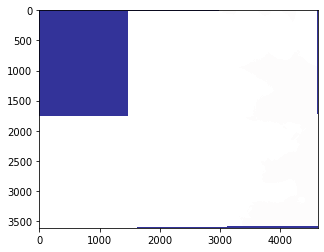

In [27]:
show(mosaic, cmap='terrain')